In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import meerkat as mk
mk.DataPanel({"y": mk.ListColumn(["ab", "cd"])})

,y (ListColumn)
0,'ab'
1,'cd'


In [4]:
from domino import explore, DominoSDM
import meerkat as mk
import numpy as np
import pandas as pd

In [4]:
dp = mk.datasets.get(
    "imagenet", 
    dataset_dir="/home/common/datasets/imagenet",
    download=False
)

,synset (PandasSeriesColumn),image_id (PandasSeriesColumn),path (PandasSeriesColumn),split (PandasSeriesColumn),image (ImageColumn),name (PandasSeriesColumn)
0,n01440764,n01440764_10026,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_10026.JPEG,train,,"tench, Tinca tinca"
1,n01440764,n01440764_10027,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_10027.JPEG,train,,"tench, Tinca tinca"
2,n01440764,n01440764_10029,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_10029.JPEG,train,,"tench, Tinca tinca"
3,n01440764,n01440764_10040,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_10040.JPEG,train,,"tench, Tinca tinca"
4,n01440764,n01440764_10042,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_10042.JPEG,train,,"tench, Tinca tinca"
...,...,...,...,...,...,...
1331162,n03388043,ILSVRC2012_val_00005961,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00005961.JPEG,valid,,fountain
1331163,n03089624,ILSVRC2012_val_00008801,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00008801.JPEG,valid,,"confectionery, confectionary, candy store"
1331164,n01518878,ILSVRC2012_val_00008176,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00008176.JPEG,valid,,"ostrich, Struthio camelus"
1331165,n03874293,ILSVRC2012_val_00004764,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00004764.JPEG,valid,,"paddlewheel, paddle wheel"

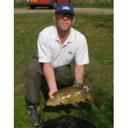
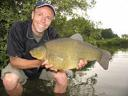
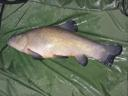
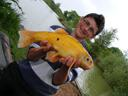
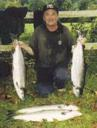
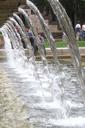
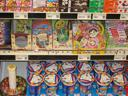
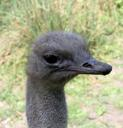
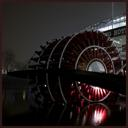
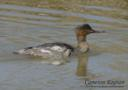

In [5]:
dp

In [10]:
valid_dp = dp.lz[dp["split"] == "valid"]

In [12]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)

In [13]:
# source: https://github.com/pytorch/vision/issues/39
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

/home/common/envs/conda/envs/domino-release/lib/python3.8/site-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [14]:
valid_dp["input"] = valid_dp["image"].to_lambda(transform)

In [15]:
import torch 
model.to(0)

@torch.autograd.no_grad()
def forward(batch):
    return model(batch.data.to(0)).cpu().numpy()

valid_dp["preds"] = valid_dp["input"].map(forward, is_batched_fn=True, batch_size=128, pbar=True)

  0%|          | 0/391 [00:00<?, ?it/s]

In [17]:
valid_dp.remove_column("input")
valid_dp.write("preds.mk")

In [25]:
valid_dp = mk.DataPanel.read("preds.mk")

In [26]:
valid_dp["pred"] = valid_dp["preds"].cpu().numpy().argmax(axis=1)


In [28]:
(valid_dp["class_idx"] == valid_dp["pred"]).mean()

0.68932

In [ ]:
valid_dp[""]

In [30]:
import nltk
import warnings 
from nltk.corpus import wordnet as wn


try:
    nltk.data.find("corpora/wordnet")
except LookupError:
    nltk.download("wordnet")


def get_hypernyms(data_dp: mk.DataPanel):
    synsets = set(data_dp["synset"].unique())
    hypernyms = []

    for synset in synsets:
        synset = wn.synset(synset)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for hypernym in synset.closure(lambda s: s.hypernyms()):
                hypernyms.append(
                    {
                        "synset": synset.name(),
                        "hypernym": hypernym.name(),
                    }
                )

    # run through the hypernyms to get their hypernyms
    df = pd.DataFrame(hypernyms)
    for hypernym in df["hypernym"].unique():
        synset = wn.synset(hypernym)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for hypernym in synset.closure(lambda s: s.hypernyms()):
                hypernyms.append(
                    {
                        "synset": synset.name(),
                        "hypernym": hypernym.name(),
                    }
                )
    return pd.DataFrame(hypernyms)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [34]:

    pos_offset_to_synset = {
        pos_offset: wn.synset_from_pos_and_offset(
            pos=pos_offset[0], offset=int(pos_offset[1:])
        ).name()
        for pos_offset in valid_dp["synset"].unique()
    }

    valid_dp["synset_pos_offset"] = valid_dp["synset"]
    valid_dp["synset"] = valid_dp["synset"].apply(lambda x: pos_offset_to_synset[x])

In [35]:
hypernym_dp = get_hypernyms(valid_dp)

In [38]:
clothing_synsets = set(hypernym_dp[hypernym_dp["hypernym"] == "clothing.n.01"]["synset"])

In [40]:
valid_dp["is_clothing"] = valid_dp["synset"].isin(clothing_synsets)

In [53]:
valid_dp["preds"].data[:, np.unique(valid_dp.lz[valid_dp["is_clothing"]]["class_idx"])].sum(axis=1)

tensor([-21.0021,  17.8777,   3.9329,  ..., -64.6743, -25.5287, -43.8976],
       device='cuda:0')

In [57]:
valid_dp["clothing_pred"]  = torch.softmax(valid_dp["preds"], dim=-1).data[:, np.unique(valid_dp.lz[valid_dp["is_clothing"]]["class_idx"])].sum(axis=1)

In [60]:
from sklearn.metrics import roc_auc_score

In [62]:
roc_auc_score(valid_dp["is_clothing"], valid_dp["clothing_pred"].cpu().numpy())

0.9889572136741132

In [67]:
valid_dp.write("preds.mk")

In [64]:
valid_dp["preds"] = valid_dp["preds"].cpu().numpy()

In [66]:
valid_dp["clothing_pred"] = valid_dp["clothing_pred"].cpu().numpy()

In [5]:
import meerkat as mk
mk.DataPanel({"y": mk.ListColumn(["ab", "cd"])})


AttributeError: module 'PIL' has no attribute 'Image'

DataPanel(nrows: 2, ncols: 1)

In [4]:
import PIL
PIL.__version__

'8.4.0'

In [3]:
PIL.__version__

'8.4.0'